In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
from scipy import integrate 
from simple_dispatch import bidStack
from simple_dispatch import GridModel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#print(sc.__version__)
colorset = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499']
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

path_string = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/MEF/'
result_date = ['20231207']

In [2]:
def results_gperkwh_fxn(numev_set, path_string, run_number, result_dates, path_string_mef=None, current_year = None):
    
    #choose plotting timeframe, result date, run number, and number of EVs

    if current_year == 2030:
        #use 2020 for uncontrolled data
        dpdf_year = '2020'
        #get reference baseline projected 2030 demand
        result_date_2030 = '20220715'
        reference_df = pd.read_csv('Results/' +'_dpdf_'+result_date_2030 + '.csv')

    elif current_year ==2019:
        dpdf_year = '2019'
        reference_df = pd.read_csv('Results/historicaldemand_2019_dpdf_20220526.csv')

    #default = 2020
    else:
        dpdf_year = '2020'
        reference_df = pd.read_csv('Results/historicaldemand_2020_dpdf_20220526.csv')

    time_period_string = '2020-01-01_to_2020-01-31'
    #time_period_string = '2020-01-01_to_2020-01-12'
    if len(result_dates[0])>1:
        result_date = result_dates[0]
        result_date_2 = result_dates[1]
    else:
        result_date = result_dates
        result_date_2 = result_dates

    #define dataframe names
    df_total_uncontrolled = {}; df_uncontrolled_dpdf = {}
    df_total_controlled = {'varying':{'access':{}, 'plugged':{}}}
    df_controlled_dpdf = {'varying':{'access':{}, 'plugged':{}}}

    for num_evs in numev_set:
        #save uncontrolled demand data in df
        if path_string_mef is None:
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
        else:
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string_mef + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
        
        df_total_uncontrolled[num_evs].datetime = pd.to_datetime(df_total_uncontrolled[num_evs].datetime)
        df_uncontrolled_dpdf[num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Uncontrolled/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
        df_uncontrolled_dpdf[num_evs].datetime = pd.to_datetime(df_uncontrolled_dpdf[num_evs].datetime)
        for signal1 in ['varying']:
            for signal2 in ['access']:
                df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
            
            for signal2 in ['plugged']:
                df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date_2+'.csv', index_col=0)
                df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date_2+'.csv')
                df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)

    num_evs = numev_set[0]
    #finds dates to plot
    # note need to do differently if spans multiple years' dpdfs
    signal1 = 'varying'
    signal2 = 'access'
    dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index

    #initialize results DataFrame
    results_gperkwh = pd.DataFrame(index=numev_set, columns=['uncontrolled', 'varying_access', 'varying_plugged'])

    #loop to get results for each number of added EVs
    for i in results_gperkwh.index:
        num_evs = int(i)
        #find total change in CO2 emissions from reference
        delta_co2 = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
        #find total change in demand from reference
        delta_demand = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()

        results_gperkwh.loc[i, 'uncontrolled'] = delta_co2/delta_demand
        
        for signal1 in ['varying']:
            signal2_set = ['access', 'plugged']

            for signal2 in signal2_set:
                delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                results_gperkwh.loc[i, signal1+'_'+signal2] = delta_co2/delta_demand

    return results_gperkwh, df_uncontrolled_dpdf, df_total_controlled, df_total_uncontrolled

In [3]:
def stacked(df_uncontrolled_dpdf, df_total_controlled, df_total_uncontrolled, dpdf_inds, num_evs, year2030=False):
    #define indices
    inds1 = np.arange(0, 24*7*60) #first week every minute
    fig, axes = plt.subplots(1, 1, figsize=(8,5), sharex=True, sharey=True)

    dt = df_total_uncontrolled[num_evs].loc[inds1, 'datetime']
    l1_uncont=df_total_uncontrolled[num_evs].loc[inds1, 'l1_demand']
    l2_uncont_temp=df_total_uncontrolled[num_evs].loc[inds1, 'l2_demand']
    l2_uncont = l2_uncont_temp-l1_uncont #- l1_uncont=df_total_uncontrolled[num_evs].loc[inds1, 'l1_demand']
    l3_uncont=df_total_uncontrolled[num_evs].loc[inds1, 'l3_demand']
    axes.stackplot(dt, l1_uncont, l2_uncont, l3_uncont, labels=['L1', 'L2', 'L3'], colors = [colorset[1], colorset[3], colorset[4]])

    axes.set_ylim([0, 1800])
    axes.set_yticks(np.arange(0, 1801, 400))
    axes.set_yticklabels(np.arange(0, 1801, 400), fontsize=13)
    dates = [day.get_text()[5:] for day in axes.get_xticklabels()]
    axes.set_xticklabels(dates, fontsize=13)
    axes.set_ylabel('EV Charging Demand [kW]', fontsize=14)
    axes.legend(loc='upper right', fontsize=14)
    axes.set_xlabel('Date', fontsize=14)

    plt.tight_layout()
    plt.savefig('Demand/S2_uncontrolled_stacked_'+str(num_evs)+ '_'+'evs.pdf', bbox_inches='tight')
    plt.show()
    return

C:\Users\sonia\AppData\Local\Temp\ipykernel_211892\2972066611.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(dates, fontsize=13)


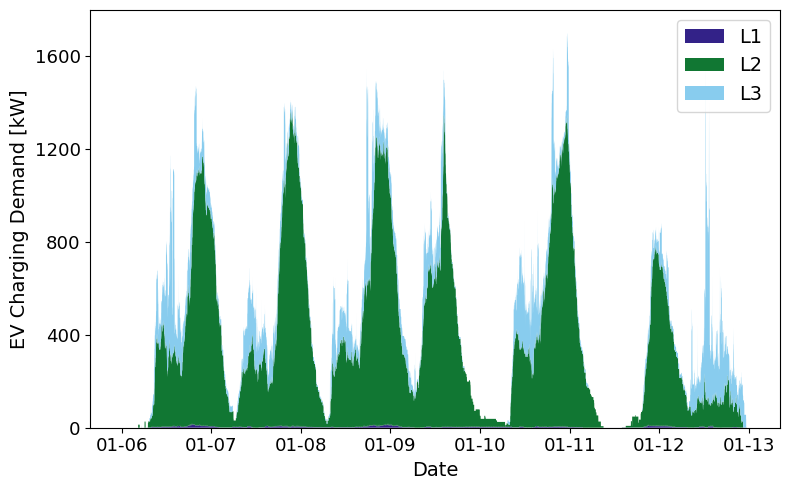

In [4]:
# Stacked Chart

num_evs = 1000
num_ev_set = [1000]


run_number = ['0']
signal1 = 'varying'
signal2 = 'access'
results_gperkwh, df_uncontrolled_dpdf, df_total_controlled, df_total_uncontrolled = results_gperkwh_fxn(num_ev_set, path_string, run_number[0], result_date[0])
dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index


stacked(df_uncontrolled_dpdf, df_total_controlled, df_total_uncontrolled, dpdf_inds, num_evs)